In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
cd /content/drive/MyDrive/researchPaperAssignment/models/zeiler

/content/drive/MyDrive/researchPaperAssignment/models/zeiler


In [32]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pickle
import os

import sys
sys.path.append(os.path.join('..', '..'))

from global_params import *

In [33]:
batch_size = 200

In [34]:
!unzip ../../data/train.zip
!unzip ../../data/test.zip

Archive:  ../../data/train.zip
replace train/Claudia_Pechstein/Claudia_Pechstein_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  ../../data/test.zip
replace test/Claudia_Pechstein/Claudia_Pechstein_0005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [35]:
train_path = os.path.join('train')

train_batches = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    # rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
).flow_from_directory(
    train_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 6352 images belonging to 901 classes.


In [37]:
#Checkpoint
checkpoint_path = "zeiler_cp.ckpt"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False, verbose=1)
logger_callback = tf.keras.callbacks.CSVLogger("history.csv", append=True)

In [38]:
# Callback for early stopping
# es_callback = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.0001,
#     patience=5,
#     restore_best_weights=True
# )

In [39]:
# Hyperparameters
epochs = 70
learning_rate = 0.05
# Math works out so that one epoch equals one pass through the training data.
train_steps_per_epoch = train_batches.n // batch_size

In [40]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (7, 7), activation='relu', strides=(2, 2), padding='same', input_shape=input_shape, name='conv1'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool1'),
    keras.layers.BatchNormalization(name='norm1'),
    
    keras.layers.Conv2D(64, (1, 1), activation='relu', strides=(1, 1), padding='same', name='conv2a'),
    keras.layers.Conv2D(192, (3, 3), activation='relu', strides=(1, 1), padding='same', name='conv2'),
    keras.layers.BatchNormalization(name='norm2'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool2'),
    
    keras.layers.Conv2D(192, (1, 1), activation='relu', strides=(1, 1), padding='same', name='conv3a'),
    keras.layers.Conv2D(384, (3, 3), activation='relu', strides=(1, 1), padding='same', name='conv3'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool3'),
    
    keras.layers.Conv2D(384, (1, 1), activation='relu', strides=(1, 1), padding='same', name='conv4a'),
    keras.layers.Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same', name='conv4'),
    
    keras.layers.Conv2D(256, (1, 1), activation='relu', strides=(1, 1), padding='same', name='conv5a'),
    keras.layers.Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same', name='conv5'),
    
    keras.layers.Conv2D(256, (1, 1), activation='relu', strides=(1, 1), padding='same', name='conv6a'),
    keras.layers.Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same', name='conv6'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same', name='pool4'),

    keras.layers.Flatten(name='flatten'),
    
    keras.layers.Dense(1024, name='fc1'),
    keras.layers.Dropout(0.2, name='drop1'),
    keras.layers.Dense(1024, name='fc2'),
    keras.layers.Dropout(0.2, name='drop2'),
    keras.layers.Dense(128, name='fc3'),
    
    keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='l2')
], name='zeiler_fergus')

In [41]:
model.summary()

Model: "zeiler_fergus"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 48, 48, 64)        3200      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 24, 24, 64)        0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 24, 24, 64)        256       
_________________________________________________________________
conv2a (Conv2D)              (None, 24, 24, 64)        4160      
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 192)       110784    
_________________________________________________________________
norm2 (BatchNormalization)   (None, 24, 24, 192)       768       
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 12, 12, 192)     

In [42]:
model.compile(
    optimizer=keras.optimizers.SGD(lr=learning_rate),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.2)
)

In [44]:
# %%script echo "Comment line with %%script echo to run this cell."

history = model.fit(
    train_batches,
    epochs=epochs,
    steps_per_epoch=train_steps_per_epoch,
    callbacks=[cp_callback, logger_callback]
)

Epoch 1/70
31/31 [==============================] - ETA: 0s - loss: 0.1962
Epoch 00001: saving model to zeiler_cp.ckpt
INFO:tensorflow:Assets written to: zeiler_cp.ckpt/assets
31/31 [==============================] - 241s 8s/step - loss: 0.1962
Epoch 2/70
31/31 [==============================] - ETA: 0s - loss: 0.1935
Epoch 00002: saving model to zeiler_cp.ckpt
INFO:tensorflow:Assets written to: zeiler_cp.ckpt/assets
31/31 [==============================] - 242s 8s/step - loss: 0.1935
Epoch 3/70
31/31 [==============================] - ETA: 0s - loss: 0.1933
Epoch 00003: saving model to zeiler_cp.ckpt
INFO:tensorflow:Assets written to: zeiler_cp.ckpt/assets
31/31 [==============================] - 243s 8s/step - loss: 0.1933
Epoch 4/70
31/31 [==============================] - ETA: 0s - loss: 0.1921
Epoch 00004: saving model to zeiler_cp.ckpt
INFO:tensorflow:Assets written to: zeiler_cp.ckpt/assets
31/31 [==============================] - 243s 8s/step - loss: 0.1921
Epoch 5/70
31/31 [==

In [ ]:
#get the latest checkpoint file
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

#Create a new model instance
model_latest_checkpoint = create_model()
# Load the previously saved weights
model_latest_checkpoint.load_weights(latest)

In [49]:
test_path = 'test'

test_batches = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
).flow_from_directory(
    test_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 1254 images belonging to 901 classes.


In [50]:
# Evaluate the network
results = model.predict(test_batches)

In [56]:
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

"""
x=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
y=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
print(x.shape)
print(y.shape)
y = y.astype(int)

import io
import tensorflow_datasets as tfds

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, label in tfds.as_numpy(test_batches):
    [out_m.write(str(label) + "\n")]
out_m.close()
"""


try:
  from google.colab import files
  files.download('vecs.tsv')
  # files.download('meta.tsv')
except:
  pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# %%script echo "Comment line with %%script echo to run this cell."

model.save('model.h5')

In [59]:
# %%script echo "Comment line with %%script echo to run this cell."

with open('history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [60]:
model = keras.models.load_model('model.h5')

In [61]:
with open('history.pickle', 'rb') as f:
    history = pickle.load(f)

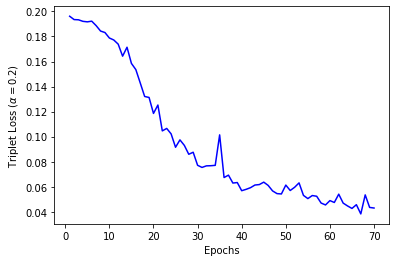

In [66]:
import matplotlib.pyplot as plt

plt.xlabel('Epochs')
plt.ylabel(r'Triplet Loss $(\alpha=0.2)$')
plt.plot(np.arange(1, len(history['loss']) + 1), history['loss'], color='b');